In [1]:
import collections
collections.Iterable = collections.abc.Iterable
from prepare_model_env import *

In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
# load dataset
dataset = Dataset(dataset_dir="../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/dataset/", augmentation=get_training_augmentation())

D:\anaconda\envs\segmentation_gpu\lib\site-packages\albumentations\augmentations\transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


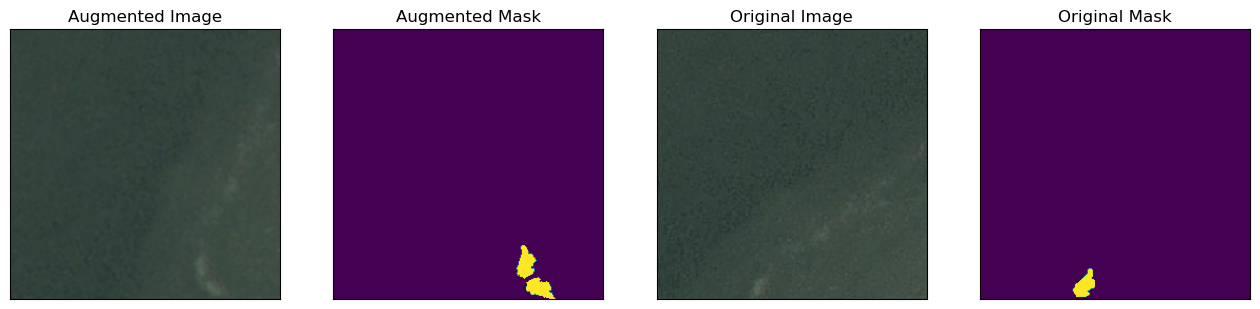

In [6]:
image, mask = dataset[55] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[55],
    original_mask= dataset.y[55]
)

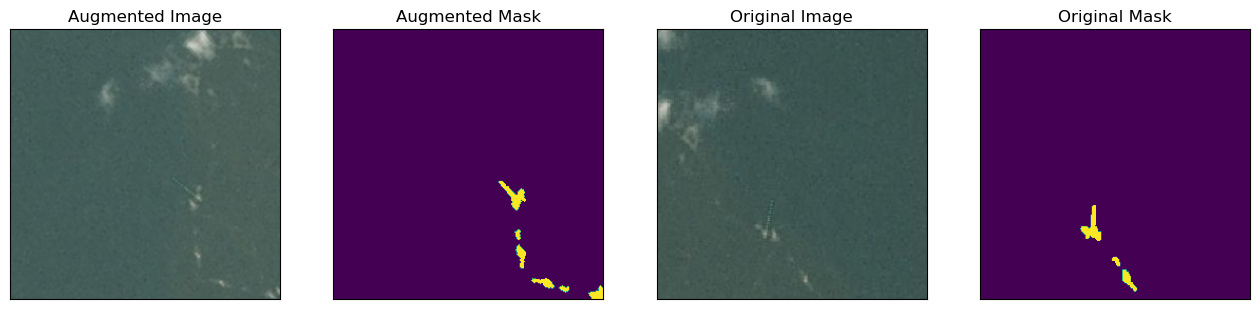

In [7]:
image, mask = dataset[12] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[12],
    original_mask= dataset.y[12]
)

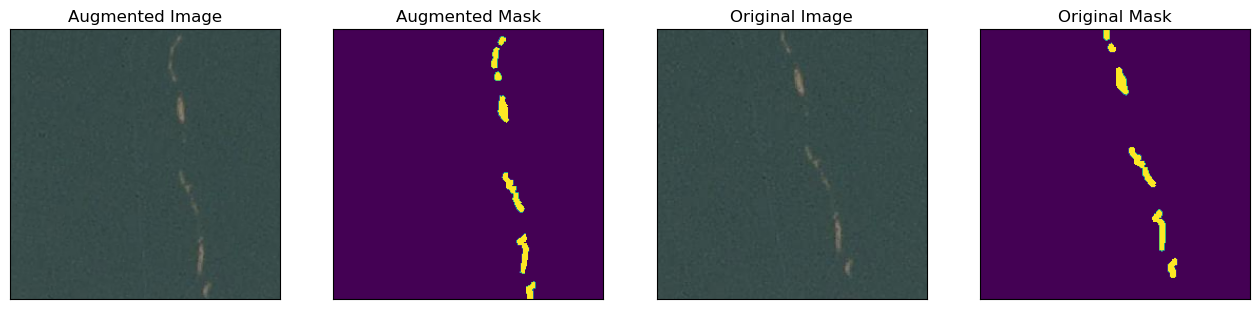

In [8]:
image, mask = dataset[155] # get some sample
visualize(
    augmented_image=image,
    augmented_mask=mask,
    original_image= dataset.x[155],
    original_mask= dataset.y[155]
)

In [9]:
with tf.device('/GPU:0'):
    # train test split
    x_train, x_val, y_train, y_val = dataset.split_data()

    # pre processing
    x_train, y_train, x_val, y_val = dataset.pre_process(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)

    # define dataloader and datasets objects for train and validation data
    train_dataset = Dataset(
        x=x_train,
        y=y_train,
        augmentation=get_training_augmentation()
    )

    valid_dataset = Dataset(
        x=x_val,
        y=y_val,
        augmentation=get_training_augmentation()
    )

In [10]:
train_dataloader = Dataloader(train_dataset, batch_size=8, shuffle=True, generate=10)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False, generate=5)

In [12]:
with tf.device('/GPU:0'):
    BACKBONE = 'efficientnetb4'
    BATCH_SIZE = 8
    EPOCHS = 20
    LR = 0.0001

    # define optomizer
    optim = keras.optimizers.Adam(LR)

    preprocess_input = sm.get_preprocessing(BACKBONE)
    # define network parameters
    n_classes = 1
    activation = 'sigmoid'

    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
    # dice loss = 1 - (2 * intersection) / (union + intersection)
    dice_loss = sm.losses.DiceLoss()
    # Binary Focal Loss = -α * (1 - p)^γ * log(p) - (1 - α) * p^γ * log(1 - p)
    # α is a weighting factor to balance the contribution of the two classes. It is typically set to the inverse of the class frequencies.
    # p is the predicted probability of the positive class.
    # γ is the focusing parameter that controls how much the loss is focused on hard examples.
    # When γ = 0, the focal loss becomes the standard binary cross-entropy loss. As γ increases,
    # the loss focuses more on hard examples, i.e., examples that are misclassified with high confidence.
    focal_loss = sm.losses.BinaryFocalLoss(gamma=2.5, alpha=0.3)

    total_loss = dice_loss + 1.5*focal_loss

    metrics = [sm.metrics.IOUScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, loss=total_loss, metrics=metrics)
    # define callbacks for learning rate scheduling and best checkpoints saving
    callbacks = [
        keras.callbacks.ModelCheckpoint('./best_model_efficientnetb4_2.h5', save_weights_only=True, save_best_only=True, mode='min', monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(),
    ]
    model.load_weights("best_model_efficientnetb4_2.h5")
    tf.config.run_functions_eagerly(True)
    history = model.fit(
    x=train_dataloader.dataset.x,
    y=train_dataloader.dataset.y,
    shuffle=train_dataloader.shuffle,
    batch_size=train_dataloader.batch_size,
    callbacks=callbacks,
    epochs=EPOCHS,
    validation_data=(valid_dataloader.dataset.x, valid_dataloader.dataset.y),
    )

Epoch 1/20


ResourceExhaustedError: Exception encountered when calling layer "block2d_project_conv" "                 f"(type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[8,64,64,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "block2d_project_conv" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(8, 64, 64, 192), dtype=float32)

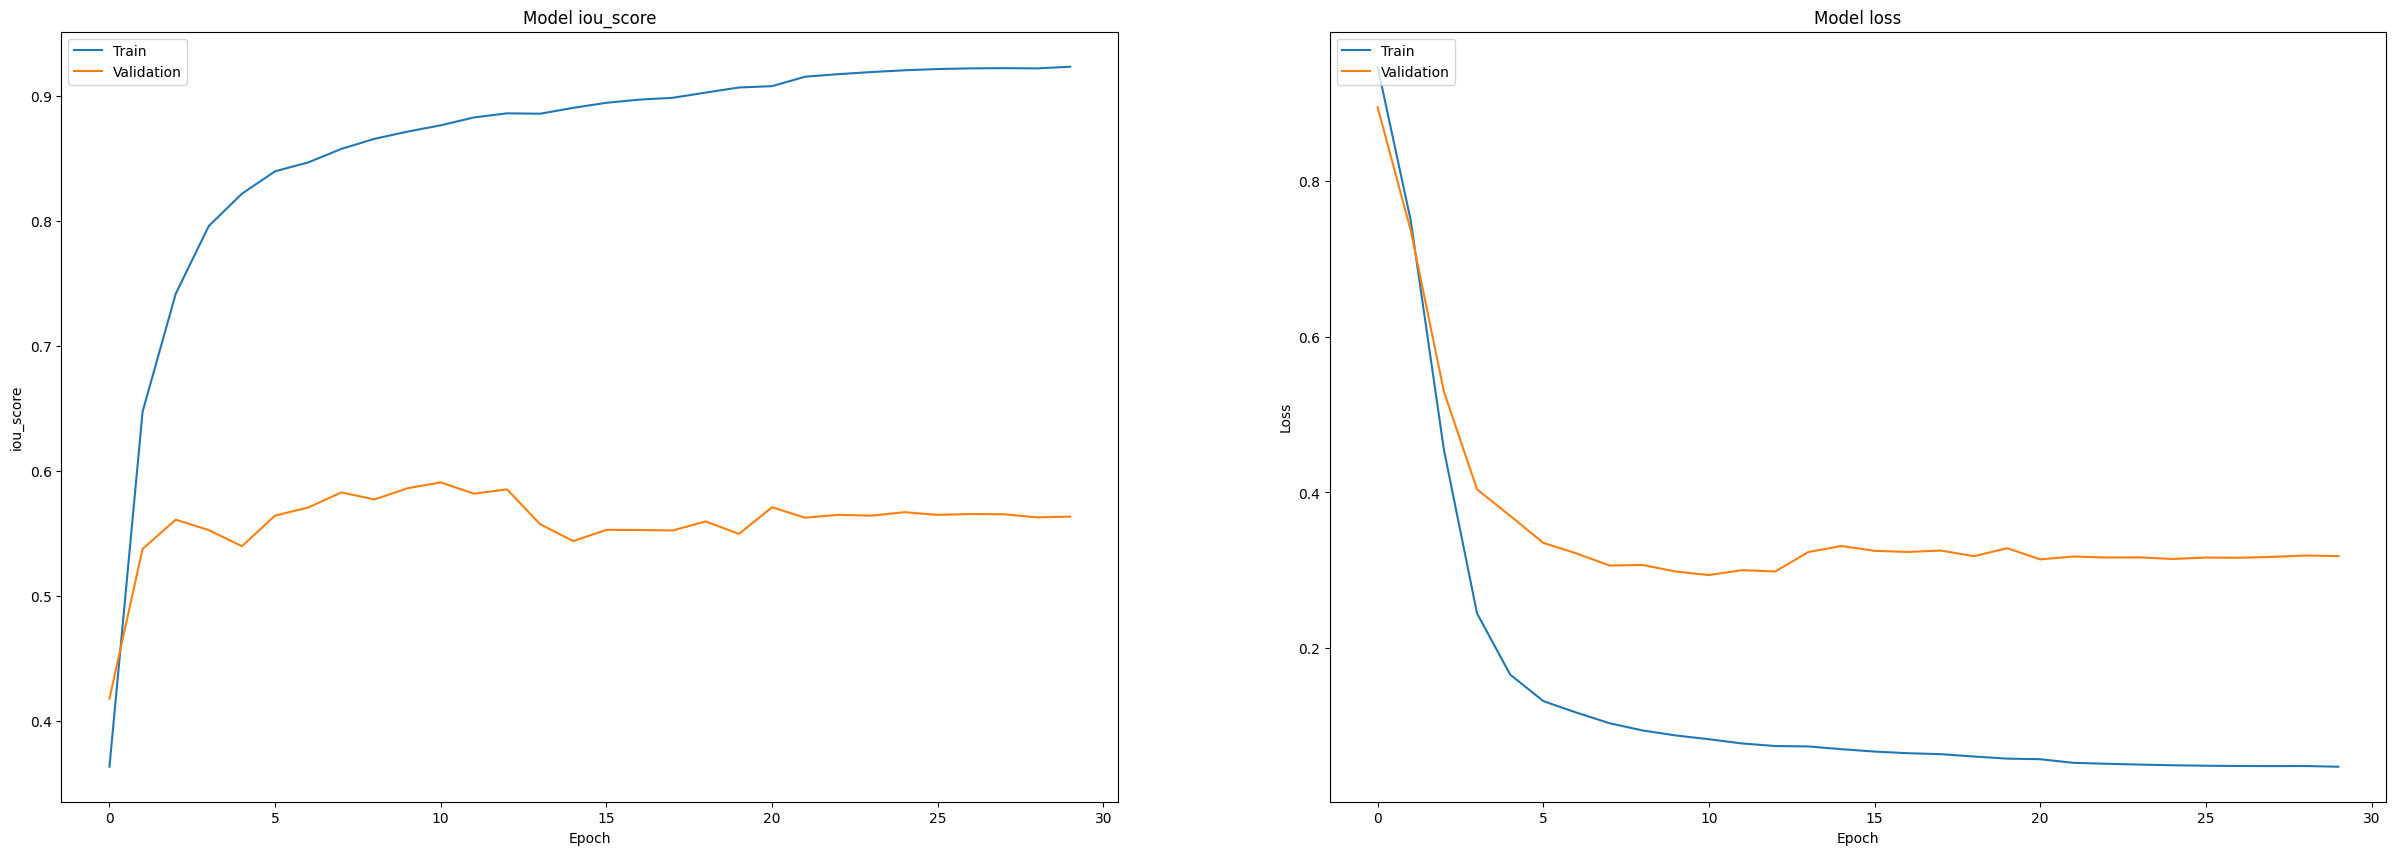

In [12]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 10))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
model.load_weights("best_model_efficientnetb7_1.h5")

1/1 [==============================] - 0s 245ms/step


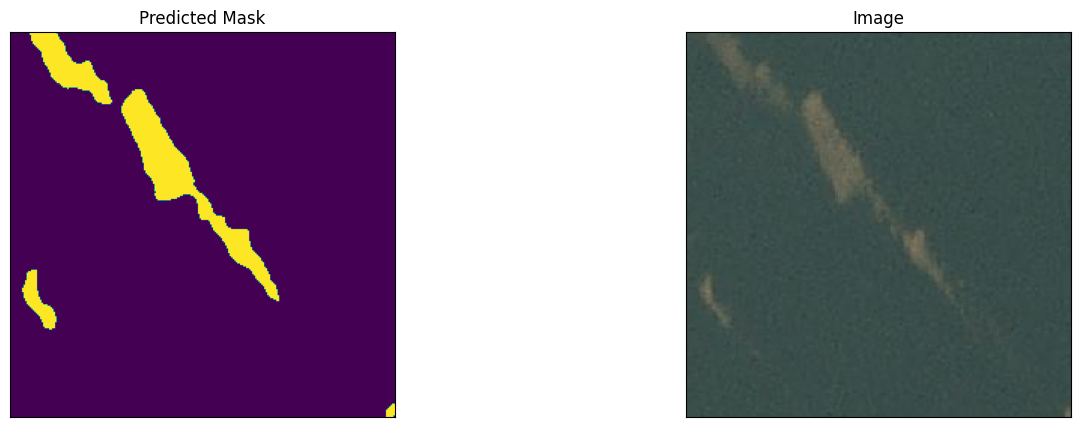

1/1 [==============================] - 0s 417ms/step


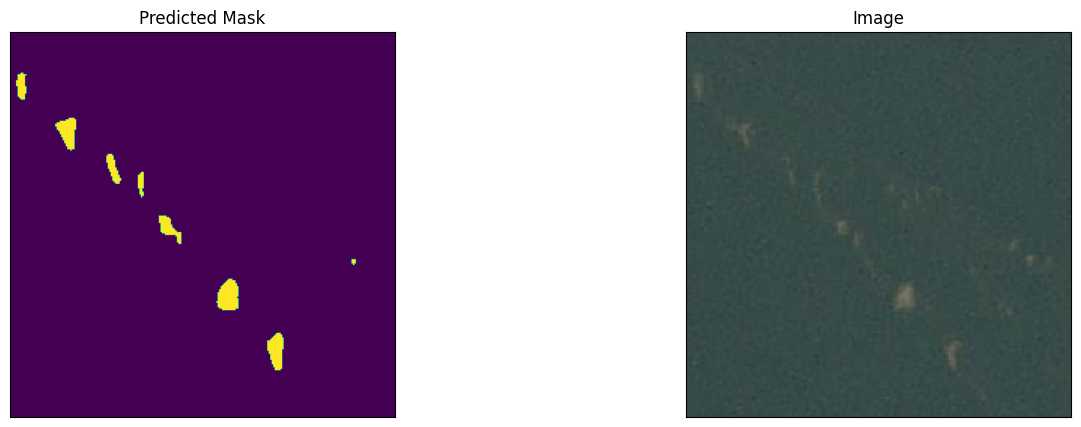

1/1 [==============================] - 0s 221ms/step


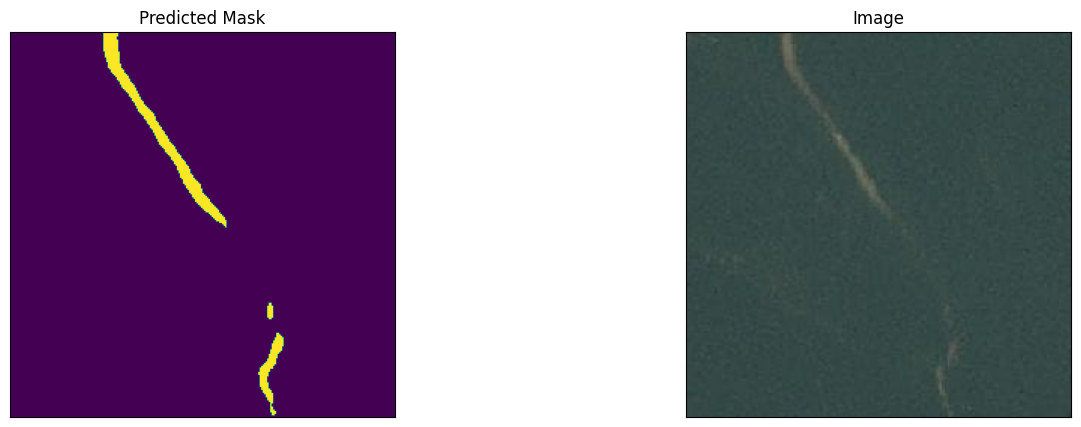

1/1 [==============================] - 0s 221ms/step


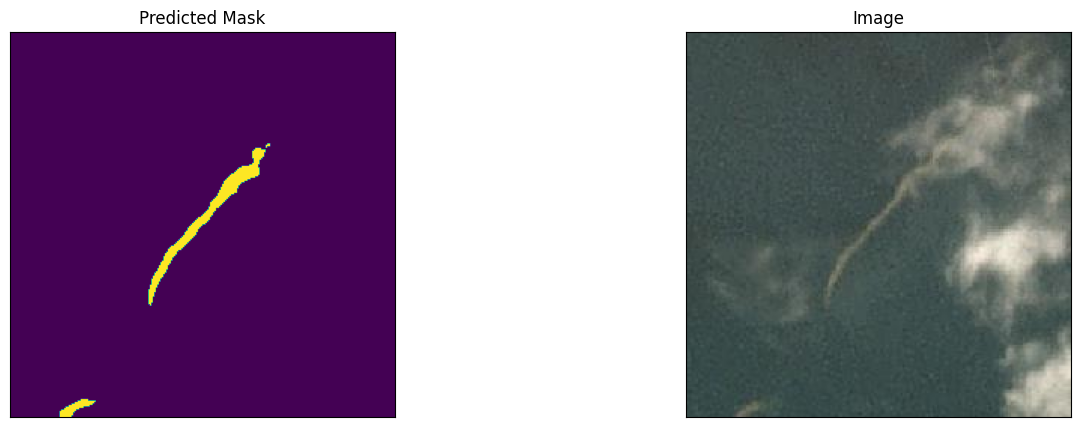

1/1 [==============================] - 0s 220ms/step


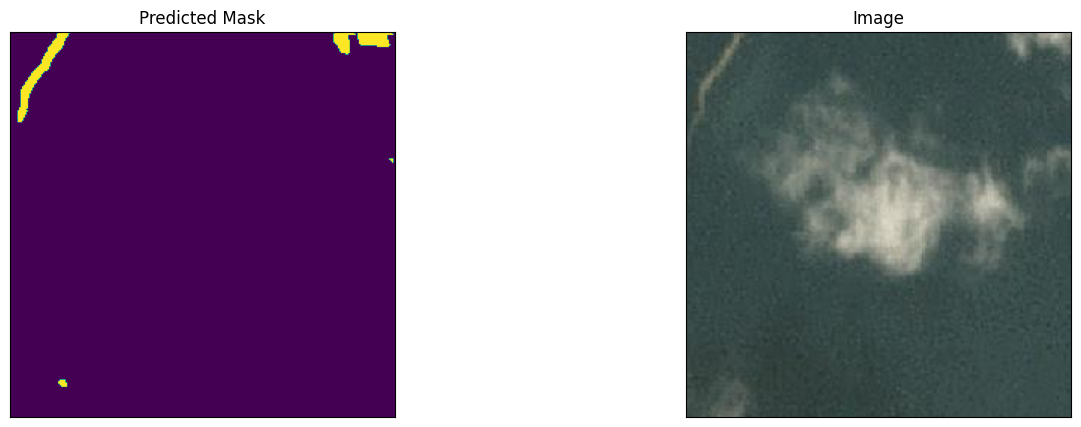

1/1 [==============================] - 0s 222ms/step


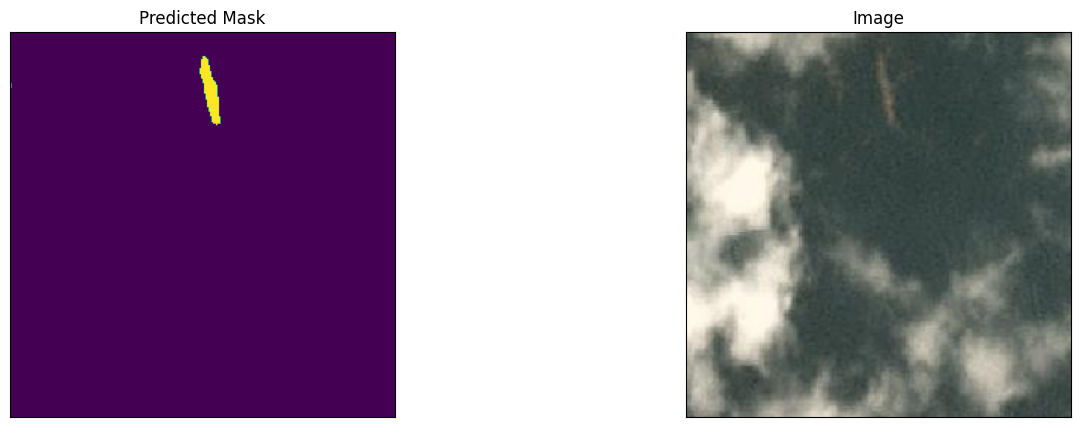

1/1 [==============================] - 0s 231ms/step


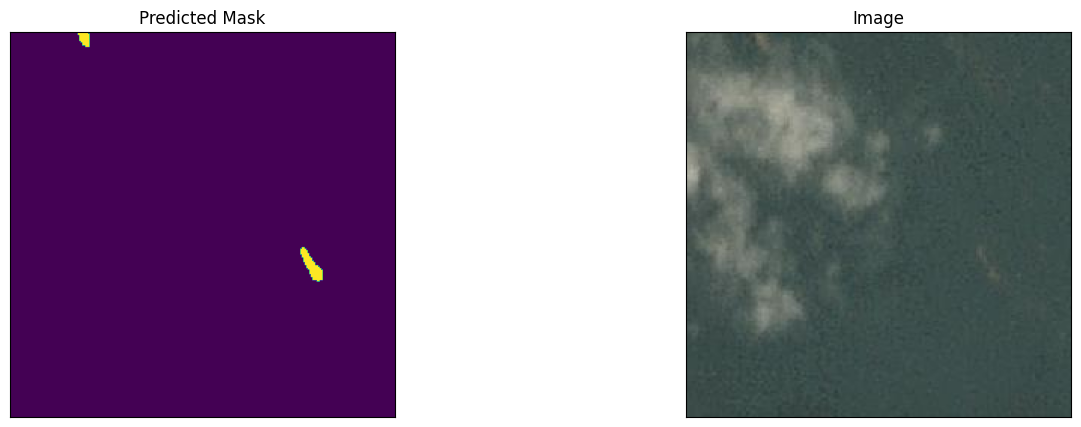

1/1 [==============================] - 0s 373ms/step


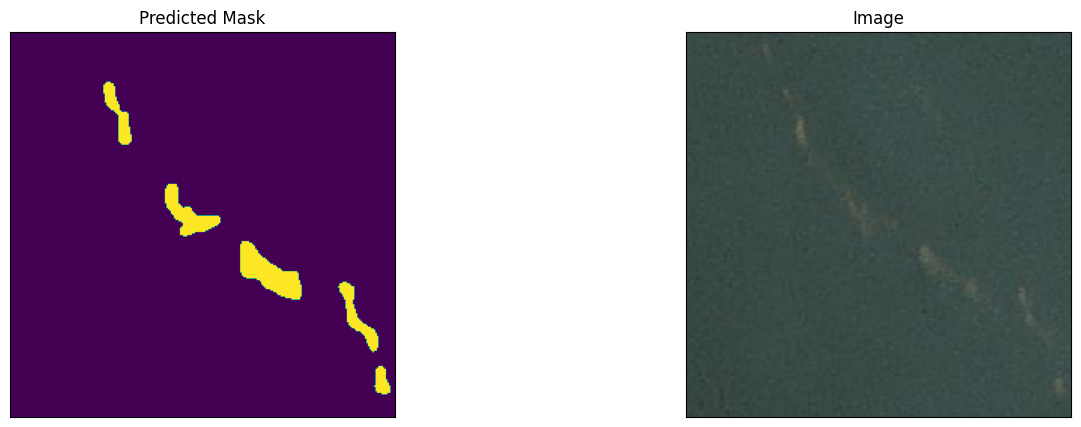

1/1 [==============================] - 0s 223ms/step


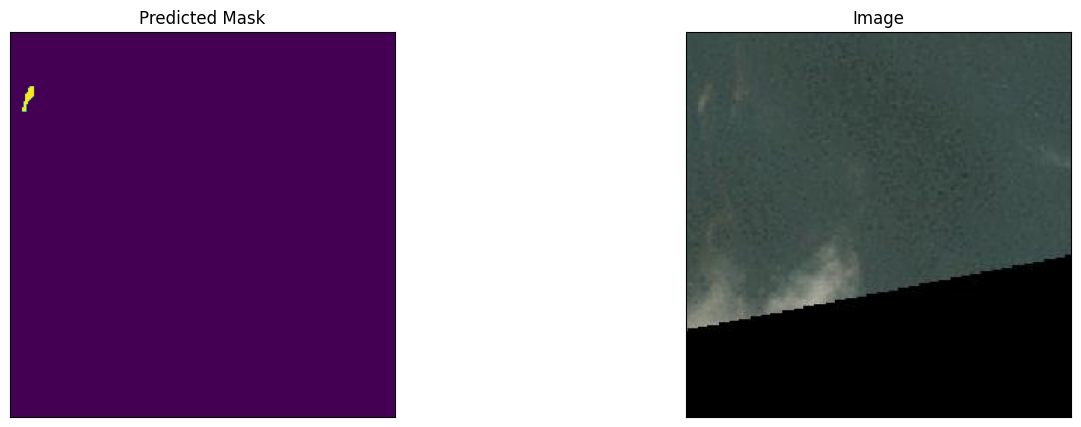

1/1 [==============================] - 0s 264ms/step


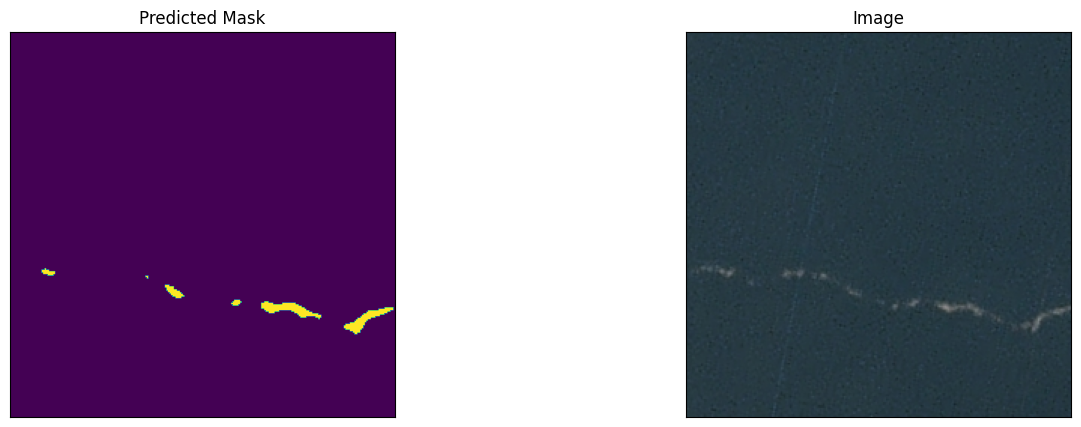

In [15]:
with tf.device("/GPU:0"):
    ## checking predictions on new unannotated images
    dataset_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/unannotated_images/"
    test_images = []
    for filename in os.listdir(dataset_dir):
        image_path = os.path.join(dataset_dir, filename)
        test_images.append(io.imread(image_path))

    for test_image in test_images:
        prediction = predict(model=model, image=test_image)
        visualize(
          predicted_mask=prediction,
          image=test_image
        )

In [16]:
with tf.device("/GPU:0"):
    import rasterio as rio
    test_mask_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/labels/"
    test_images_dir = "../../datasets/marine_debris_detection/marine_debris-semantic_segmentation/test/images/"
    ## checking predictions on new unannotated images
    test_images = []
    test_masks = []
    for filename in os.listdir(test_images_dir):
        image_path = os.path.join(test_images_dir, filename)
        test_images.append(io.imread(image_path))
        mask_path = os.path.join(test_mask_dir, filename.split('.')[0]+"_marineDebris.ome.tiff")
        with rio.open(mask_path) as mask :
            masknp = mask.read()
        test_masks.append(np.where(masknp[0] > 0, 1, masknp[0]))

D:\anaconda\envs\segmentation_gpu\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [18]:
test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_masks = tf.cast(test_masks, tf.float32)

In [19]:
efficientnetb7_results = model.evaluate(test_images, test_masks)

2/2 [==============================] - 3s 1s/step - loss: 0.3474 - iou_score: 0.5417
